####Download ECSE415 Vehicle Dataset & car dataset from Stanford University

In [1]:
import os

def download_datasets(datasets):
    """
      Download vehicle/non-vehicle datasets from various sources.

      Params
      ------
      - datasets: list strings representing keys of each dataset. Possible values: ('ecse415', 'udacity')
    """
    Params
    ------
  cmds = list()
  # McGill ECSE415 Provided Image Sequences
  if 'ecse415' in datasets and not os.path.exists("dataset"):
    cmds.append('wget -nc -O dataset.zip https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1')
    cmds.append('unzip dataset.zip')
    cmds.append('rm dataset.zip')

  # Stanford University Cars Dataset
  if 'stanford' in datasets and not os.path.exists("cars_test"):
    cmds.append('wget -nc http://ai.stanford.edu/~jkrause/car196/cars_test.tgz')
    cmds.append('tar -xf cars_test.tgz')
    cmds.append('rm cars_test.tgz')

  # Udacity Vehicles and Non-Vehicles Dataset
  if 'udacity' in datasets:
    if not os.path.exists("vehicles"):
      cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip')
      cmds.append('unzip vehicles.zip')
      cmds.append('rm vehicles.zip')

    if not os.path.exists("non-vehicles"):
      cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip')
      cmds.append('unzip non-vehicles.zip')
      cmds.append('rm non-vehicles.zip')

    if os.path.exists("__MACOSX"):
      cmds.append('rm -r __MACOSX')

  for cmd in cmds:
    os.system(cmd)

def remove_datasets(datasets):
  cmds = list()
  
  if 'ecse415' in datasets and os.path.exists("dataset"):
    cmds.append('rm -r dataset')

  if 'stanford' in datasets and os.path.exists("cars_test"):
    cmds.append('rm -r cars_test')

  if 'udacity' in datasets:
    if os.path.exists("vehicles"):
      cmds.append('rm -r vehicles')

    if os.path.exists("non-vehicles"):
      cmds.append('rm -r non-vehicles')

  for cmd in cmds:
    os.system(cmd)

In [2]:
download_datasets(['udacity', 'ecse415'])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
    Params
    ------
    Parse gt.txt with format
      <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
    Return dict as:
      <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
      key: frame
      value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    Params
    ------
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

In [4]:
def intersection(r1, r2):
  '''
      Compute intersection rectangle of two rectangles

      Params
      ------
      r1: tuple (x1,y1,x2,y2) coordinates of rectangle 1
      r2: tuple (x1,y1,x2,y2) coordinates of rectangle 2

      return area interesction rectangle
  '''
  # x axis

  # r2 in r1
  if r1[0] <= r2[0] and r1[2] >= r2[2]:
    x1, x2 = r2[0], r2[2]

  # r1 in r2
  elif r2[0] <= r1[0] and r2[2] >= r1[2]:
    x1, x2 = r1[0], r1[2]

  # r1 left of r2 and overlap
  elif r1[0] <= r2[0] and r1[2] >= r2[0]:
    x1, x2 = r2[0], r1[2]

  # r2 left of r1 and overlap
  elif r2[0] <= r1[0] and r2[2] >= r1[0]:
    x1, x2 = r1[0], r2[2]

  # no overlap
  else:
    return None

  # y axis

  # r2 in r1
  if r1[1] <= r2[1] and r1[3] >= r2[3]:
    y1, y2 = r2[1], r2[3]

  # r1 in r2
  if r2[1] <= r1[1] and r2[3] >= r1[3]:
    y1, y2 = r1[1], r1[3]

  # r1 top of r2 and overlap
  elif r1[1] <= r2[1] and r1[3] >= r2[1]:
    y1, y2 = r2[1], r1[3]

  # r2 top of r1 and overlap
  elif r2[1] <= r1[1] and r2[3] >= r1[1]:
    y1, y2 = r1[1], r2[3]

  # no overlap
  else:
    return None

  return int(x1), int(y1), int(x2), int(y2)


def area(r):
  '''
      Params
      ------
      Rectangle area

      r: tuple (x1,y1,x2,y2) coordinates of rectangle
      
      return area
  '''
  return (r[2]-r[0])*(r[3]-r[1])

###**Sliding Window**

In [9]:
def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False):

    """
    Run a sliding window across an input image and return a list of the
    coordinates of each window.
    Window travels the width of the image (in the +x direction) at a range of
    heights (toward the bottom of the image in the +y direction). At each
    successive y, the size of the window is increased by a factor equal to

    Params
    ------
    - scale. The horizontal search area is limited by @param x_range
    and the vertical search area by @param y_range.
    - image_size (int, int): Size of the image (width, height) in pixels.
    - init_size (int, int): Initial size of of the window (width, height)
        in pixels at the initial y, given by @param y_range[0].
    - x_overlap (float): Overlap between adjacent windows at a given y
        as a float in the interval [0, 1), where 0 represents no overlap
        and 1 represents 100% overlap.
    - y_step (float): Distance between successive heights y as a
        fraction between (0, 1) of the total height of the image.
    - x_range (float, float): (min, max) bounds of the horizontal search
        area as a fraction of the total width of the image.
    - y_range (float, float) (min, max) bounds of the vertical search
        area as a fraction of the total height of the image.
    - scale (float): Factor by which to scale up window size at each y.
    -  windows: List of tuples, where each tuple represents the
        coordinates of a window in the following order: (upper left corner
        x coord, upper left corner y coord, lower right corner x coord,
        lower right corner y coord).
    """

    windows = []
    y_count = 0
    h, w = image_size[1], image_size[0]
    init_size = (0.1*h, 0.1*w)
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        y_count += 1
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    if (dims):
        return windows, y_count
    return windows

##**Build Dataset**


Positive samples are obtained from the bounding box provided in the 4 image sequences from the ECSE415 dataset and from the car images from the Stanford University dataset.

Negative samples are obtained by generating random patches which intersect minimally with vehicles from the 4 image sequences from the ECSE415 dataset.

In [5]:
from random import uniform
def more_bboxes(bbox,img_dim,  number_of_bboxes=10, x_scale=(1,1.02), y_scale=(0.98,1.02), x_translate=(-0.02,0.02), y_translate=(-0.02,0.02)):
  '''
      Generate list of bounding boxes around box of interest by applying random transations and scaling.

      Params
      ------
      - param bbox: the bounding box of interest
      - img_dim: dimensions of the full image
      - number_of_bboxes: the number of new bboxes to generate
      - x_scale: how much to scale the new bboxes around the bbox of interest on the x axis
      - y_scale: how much to scale the new bboxes around the bbox of interest on the y axis
      - x_translate: how much to translate the new bboxes around the bbox of interest on the x axis
      - y_translate: how much to translate the new bboxes around the bbox of interest on the y axis

      Return
      ------
      return list of randomly generated bounding boxes around the box of interest.
  '''
  # bounds
  x_left_bound, x_right_bound = 0, img_dim[1]
  y_top_bound, y_bottom_bound = 0, img_dim[1]
  x1, y1, x2, y2 = bbox
  w = float(x2 - x1)
  h = float(y2 - y1)

  bboxes = list()

  # print("init:",bbox)
  for i in range(number_of_bboxes):
    while(True):
      random_x_scale =  uniform(x_scale[0],x_scale[1])
      random_y_scale = uniform(y_scale[0],y_scale[1])
      random_x_translate = uniform(w*x_translate[0],w*x_translate[1])
      random_y_translate = uniform(h*y_translate[0],h*y_translate[1])

      # print("scales: ",random_x_scale,random_y_scale,random_x_translate,random_y_translate)

      # Scale
      new_x1, new_x2 = int(x1 * (1/random_x_scale)), int(x2 * random_x_scale)
      new_y1, new_y2 = int(y1 * (1/random_y_scale)), int(y2 * random_y_scale)

      # Translate
      new_x1, new_x2 = int(new_x1 + random_x_translate), int(new_x2 + random_x_translate)
      new_y1, new_y2 = int(new_y1 + random_y_translate), int(new_y2 + random_y_translate)

      # print("post transform: ", new_x1, new_y1, new_x2, new_y2)
      #validate x1
      if new_x1 < x_left_bound:
        new_x1 = x_left_bound

      if new_x1 > x_right_bound:
        continue

      #validate x2
      if new_x2 < x_left_bound:
        continue

      if new_x2 > x_right_bound:
        new_x2 = x_right_bound

      #validate y1
      if new_y1 < y_top_bound:
        new_y1 = y_top_bound

      if new_y1 > y_bottom_bound:
        continue

      #validate y2
      if new_y2 < y_top_bound:
        continue

      if new_y2 > y_bottom_bound:
        new_y2 = y_bottom_bound

      # Validate
      if new_x2 <= new_x1 or new_y2 <= new_y1:
        continue

      # OK
      bboxes.append((new_x1,new_y1,new_x2,new_y2))
      break
  return bboxes


In [6]:
import os
import cv2 as cv
import os
from random import randint, shuffle, choice
from skimage.transform import resize
import matplotlib.pyplot as plt

def build_dataset_from_sequences(sequences,min_intersection_ratio=0.9, number_of_positive_samples_per_sequence=1000, number_of_negative_samples_per_sequence=4000, visualize=False):
  '''
      Build a dataset from provided image sequences and other external datasets. The built dataset consists of a 
      dictionary. Each key corresponds to a sequence of images. The image sequences can be split and used for training.

      Params
      ------
      - min_intersection_ratio: minimum intersection with truth bounding box to be considered a vehicle.
      - sequences: list of sequences ids from which to extract patches.
      - number_of_positive_samples_per_sequence: number of vehicle samples to generate.
      - number_of_negative_samples_per_sequence: number of non-vehicle samples to generate.
      - visualize: if True, display extracted images, otherwise, don't display.

      Return
      ------
      return a tuple (imgs, labels) where imgs are the extracted images from the sequences
      and labels is a numpy array of the associated labels.
  '''

  # Build sequence dictionary
  number_of_sequences = len(sequences)


  N = number_of_negative_samples_per_sequence*number_of_sequences + number_of_positive_samples_per_sequence*number_of_sequences

  imgs = list()
  
  labels = list()

  for seq_id in sequences:
    bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))

    # init sliding window
    img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=1))
    windows = slidingWindow(img.shape[0:2], init_size=(64,64), x_overlap=0.05, y_step=0.05,x_range=(0, 1), y_range=(0, 1), scale=1.1, dims=False)

    ################
    # NEGATIVE SET #
    ################

    # Apply sliding window and add samples with minimal interesection with vehicle boxes
    for i in range(number_of_negative_samples_per_sequence):

      frame_id = choice(list(bboxes.keys()))
      vehicle_bboxes = bboxes[frame_id]
      img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))


      random_window = choice(windows)

      random_window_x1, random_window_y1, random_window_x2, random_window_y2 = random_window
      random_window_area = area(random_window)

      # check intersection with vehicles
      is_vehicle = 0
      for (id, x1,y1,x2,y2) in vehicle_bboxes:
        vehicle_bbox = (x1,y1,x2,y2)
        vehicle_area = area(vehicle_bbox)

        intersection_bbox = intersection(vehicle_bbox, random_window)
        
        # not a vehicle
        if intersection_bbox is None:
          continue
        else:
          intersection_area = area(intersection_bbox)
          # check for minimal intersection
          if intersection_area/vehicle_area > min_intersection_ratio and intersection_area/random_window_area > min_intersection_ratio:       
            is_vehicle = 1
            break

      random_bbox_img = img[random_window_y1:random_window_y2,random_window_x1:random_window_x2]

      imgs.append(random_bbox_img)
      labels.append(is_vehicle)

      if visualize:
        plt.imshow(random_bbox_img)
        plt.xticks([]), plt.yticks([])
        plt.show()  
        print("label: ",is_vehicle)

    ################
    # POSITIVE SET #
    ################
    sequence_complete = False
    positive_count = 0
    while(not sequence_complete):

      frame_id = choice(list(bboxes.keys()))
      vehicle_bboxes = bboxes[frame_id]
      img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))

      for (id, x1,y1,x2,y2) in vehicle_bboxes:

        if sequence_complete:
          break

        vehicle_bbox = (x1,y1,x2,y2)
        new_bboxes = more_bboxes(vehicle_bbox,img.shape[0:2], number_of_bboxes=1)

        for new_bbox in new_bboxes:

          if sequence_complete:
            break

          new_bbox_img = img[new_bbox[1]:new_bbox[3],new_bbox[0]:new_bbox[2]]

          imgs.append(new_bbox_img)
          labels.append(1)
          positive_count += 1

          if visualize:
            plt.imshow(new_bbox_img)
            plt.xticks([]), plt.yticks([])
            plt.show()
            print("label: ",1)

          if positive_count >= number_of_positive_samples_per_sequence:
            sequence_complete = True
  return imgs, np.array(labels)

In [7]:
import os
import cv2 as cv
import numpy as np
import os
from random import randint, shuffle, choice
from skimage.transform import resize
import sys

def build_dataset_from_udacity(number_of_positive_samples=2000, number_of_negative_samples=4000, visualize=False):
  '''
      Build a dataset from udacity vehicle/non-vehicle dataset.

      Params
      ------
      - number_of_negative_samples: The number of negative samples to extract. 
      - number_of_positive_samples: The number of positive samples to extract. 
      - visualize: if True, display extracted images, otherwise, don't display.

      Return
      ------
      return a tuple (imgs, labels). imgs is a numpy array with shape N x H x W x C where N is the number of samples, H is the images height,
      W is the images width and C is the number of channels. labels correspond to the labels associated with each image
  '''
  imgs = list()
  labels = list()

  # ------------------------------------------------------ #
  # -------------------- Positive Set -------------------- #
  # ------------------------------------------------------ #

  vehicle_db_main_path = 'vehicles/'
  vehicle_db_subpaths= ['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']

  samples_available = 0

  vehicle_db_dict = dict()
  for db in vehicle_db_subpaths:
    vehicle_db_dict[db] = dict()
    vehicle_db_dict[db]['length'] = len(os.listdir(vehicle_db_main_path+db))
    samples_available += vehicle_db_dict[db]['length']

    inds = list(range(vehicle_db_dict[db]['length']))
    shuffle(inds)
    vehicle_db_dict[db]['inds'] = inds
    vehicle_db_dict[db]['i'] = 0

  if samples_available < number_of_negative_samples:
      print("Error: {av} positive samples available, but {req} required.".format(av=samples_available, req=number_of_negative_samples))
      sys.exit(-1)

  for i in range(number_of_positive_samples):
    while(True):
      random_db = choice(list(vehicle_db_dict.keys()))

      if vehicle_db_dict[random_db]['i'] >= vehicle_db_dict[random_db]['length']:
        continue

      random_id = vehicle_db_dict[random_db]['inds'][vehicle_db_dict[random_db]['i']]
      vehicle_db_dict[random_db]['i'] += 1

      filepath = vehicle_db_main_path + random_db + '/' + os.listdir(vehicle_db_main_path+random_db)[random_id]
      if not filepath.endswith('.png'):
        continue
      break

    img = cv.imread(vehicle_db_main_path + random_db + '/' + os.listdir(vehicle_db_main_path+random_db)[random_id])
    imgs.append(img)
    labels.append(1)

  # ------------------------------------------------------ #
  # -------------------- Negative Set -------------------- #
  # ------------------------------------------------------ #

  non_vehicle_db_main_path = 'non-vehicles/'
  non_vehicle_db_subpaths= ['Extras','GTI']

  samples_available = 0

  non_vehicle_db_dict = dict()
  for db in non_vehicle_db_subpaths:
    non_vehicle_db_dict[db] = dict()
    non_vehicle_db_dict[db]['length'] = len(os.listdir(non_vehicle_db_main_path+db))

    inds = list(range(non_vehicle_db_dict[db]['length']))
    samples_available += non_vehicle_db_dict[db]['length']

    shuffle(inds)
    non_vehicle_db_dict[db]['inds'] = inds
    non_vehicle_db_dict[db]['i'] = 0

  if samples_available < number_of_negative_samples:
      print("Error: {av} negative samples available, but {req} required.".format(av=samples_available, req=number_of_negative_samples))
      sys.exit(-1)

  for i in range(number_of_negative_samples):
    while(True):
      random_db = choice(list(non_vehicle_db_dict.keys()))

      if non_vehicle_db_dict[random_db]['i'] >= non_vehicle_db_dict[random_db]['length']:
        continue

      random_id = non_vehicle_db_dict[random_db]['inds'][non_vehicle_db_dict[random_db]['i']]
      non_vehicle_db_dict[random_db]['i'] += 1

      filepath = non_vehicle_db_main_path + random_db + '/' + os.listdir(non_vehicle_db_main_path+random_db)[random_id]
      if not filepath.endswith('.png'):
        continue
      break

    img = cv.imread(non_vehicle_db_main_path + random_db + '/' + os.listdir(non_vehicle_db_main_path+random_db)[random_id])
    imgs.append(img)
    labels.append(0)


  return imgs, np.array(labels)


###Display 5 Vehicle and 5 Non-Vehicle from Provided Sequences

In [34]:
imgs, labels = build_dataset_from_sequences(['0','1','2'],min_intersection_ratio=0.8, number_of_positive_samples_per_sequence=200, number_of_negative_samples_per_sequence=400, visualize=False)


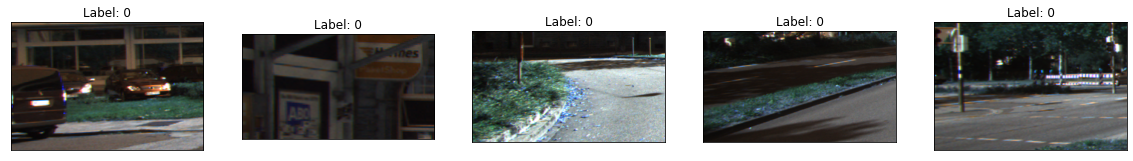

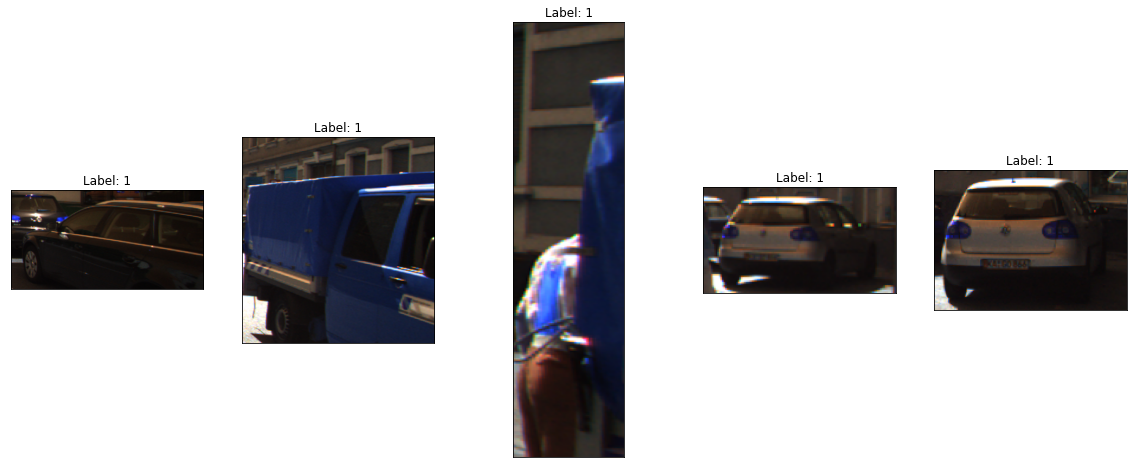

In [43]:
# Display Images along with predictions

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

number_of_samples = len(imgs)

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_samples-1)
    
    if labels[id] == 1:
      continue

    if id in visited:
      continue
    
    axes[i].set_title("Label: {true}".format(true=labels[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_samples-1)
    
    if labels[id] == 0:
      continue

    if id in visited:
      continue
    
    axes[i].set_title("Label: {true}".format(true=labels[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()


###Display 5 Vehicle and 5 Non-Vehicle from Udacity Dataset



In [12]:
imgs, labels = build_dataset_from_udacity(number_of_positive_samples=5, number_of_negative_samples=5, visualize=False)

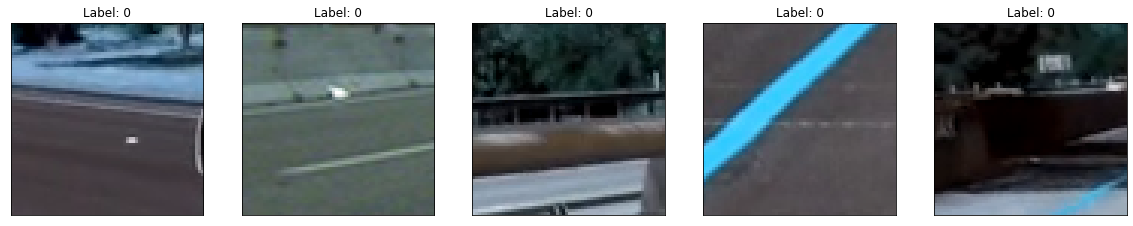

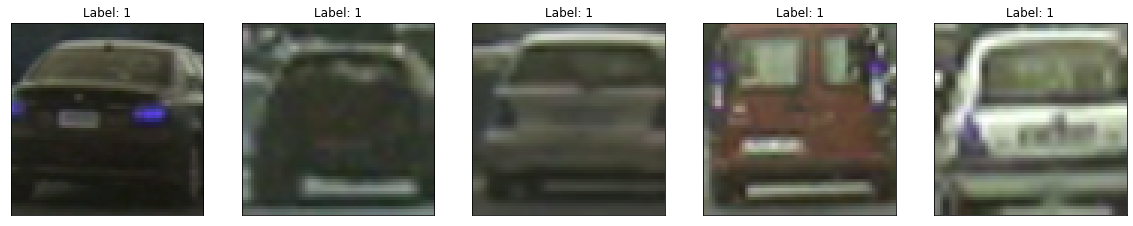

In [13]:
# Display Images along with predictions

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

number_of_samples = len(imgs)

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_samples-1)
    
    if labels[id] == 1:
      continue

    if id in visited:
      continue
    
    axes[i].set_title("Label: {true}".format(true=labels[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

number_of_samples = len(imgs)

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_samples-1)
    
    if labels[id] == 0:
      continue

    if id in visited:
      continue
    
    axes[i].set_title("Label: {true}".format(true=labels[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()


###**Dataset Statistics**

In [15]:
import numpy as np

def dataset_statistics(imgs, labels, statistic_types):
  '''
      Collect width, height, and aspect ratios statistics from image dataset.

      Params
      ------
      imgs: a list of images
      labels: 2D numpy array labels associated with the images
      statistics: list containing the statistics to compute. Can contain the following values: 'width', 'height',
                  'aspect_ratio', 'class_distribution'.
      
      Return
      ------
      return a dictionary of statistics. For height, width, and aspect ratio, the value is a min-max tuple.
                                         For class_distribution, the value is an array of counts per class.
  '''
  # Number of samples
  number_of_samples = len(imgs)

  # Class distribution
  if 'class_distribution' in statistic_types:
    class_count = np.zeros(2)

  # compute statistics on full image dataset
  if 'aspect_ratio' in statistic_types:
    aspect_ratios = np.zeros(number_of_samples)

  if 'width' in statistic_types:
    widths = np.zeros(number_of_samples)

  if 'height' in statistic_types:
    heights = np.zeros(number_of_samples)

  i = 0
  for i in range(number_of_samples):

    if 'width' in statistic_types:
      widths[i] = imgs[i].shape[1]

    if 'height' in statistic_types:
      heights[i] = imgs[i].shape[0]

    if 'aspect_ratio' in statistic_types:
      aspect_ratios[i] = heights[i] / float(widths[i])
    
    if 'class_distribution' in statistic_types:
      class_count[labels[i]] += 1

  stats = dict()
  if 'width' in statistic_types:
    stats['widths'] = widths    

  if 'height' in statistic_types:
    stats['heights'] = heights

  if 'aspect_ratio' in statistic_types:
    stats['aspect_ratios'] = aspect_ratios
          
  if 'class_distribution' in statistic_types:
    stats['class_distribution'] = class_count
  
  return stats

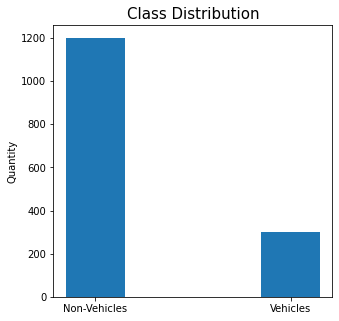

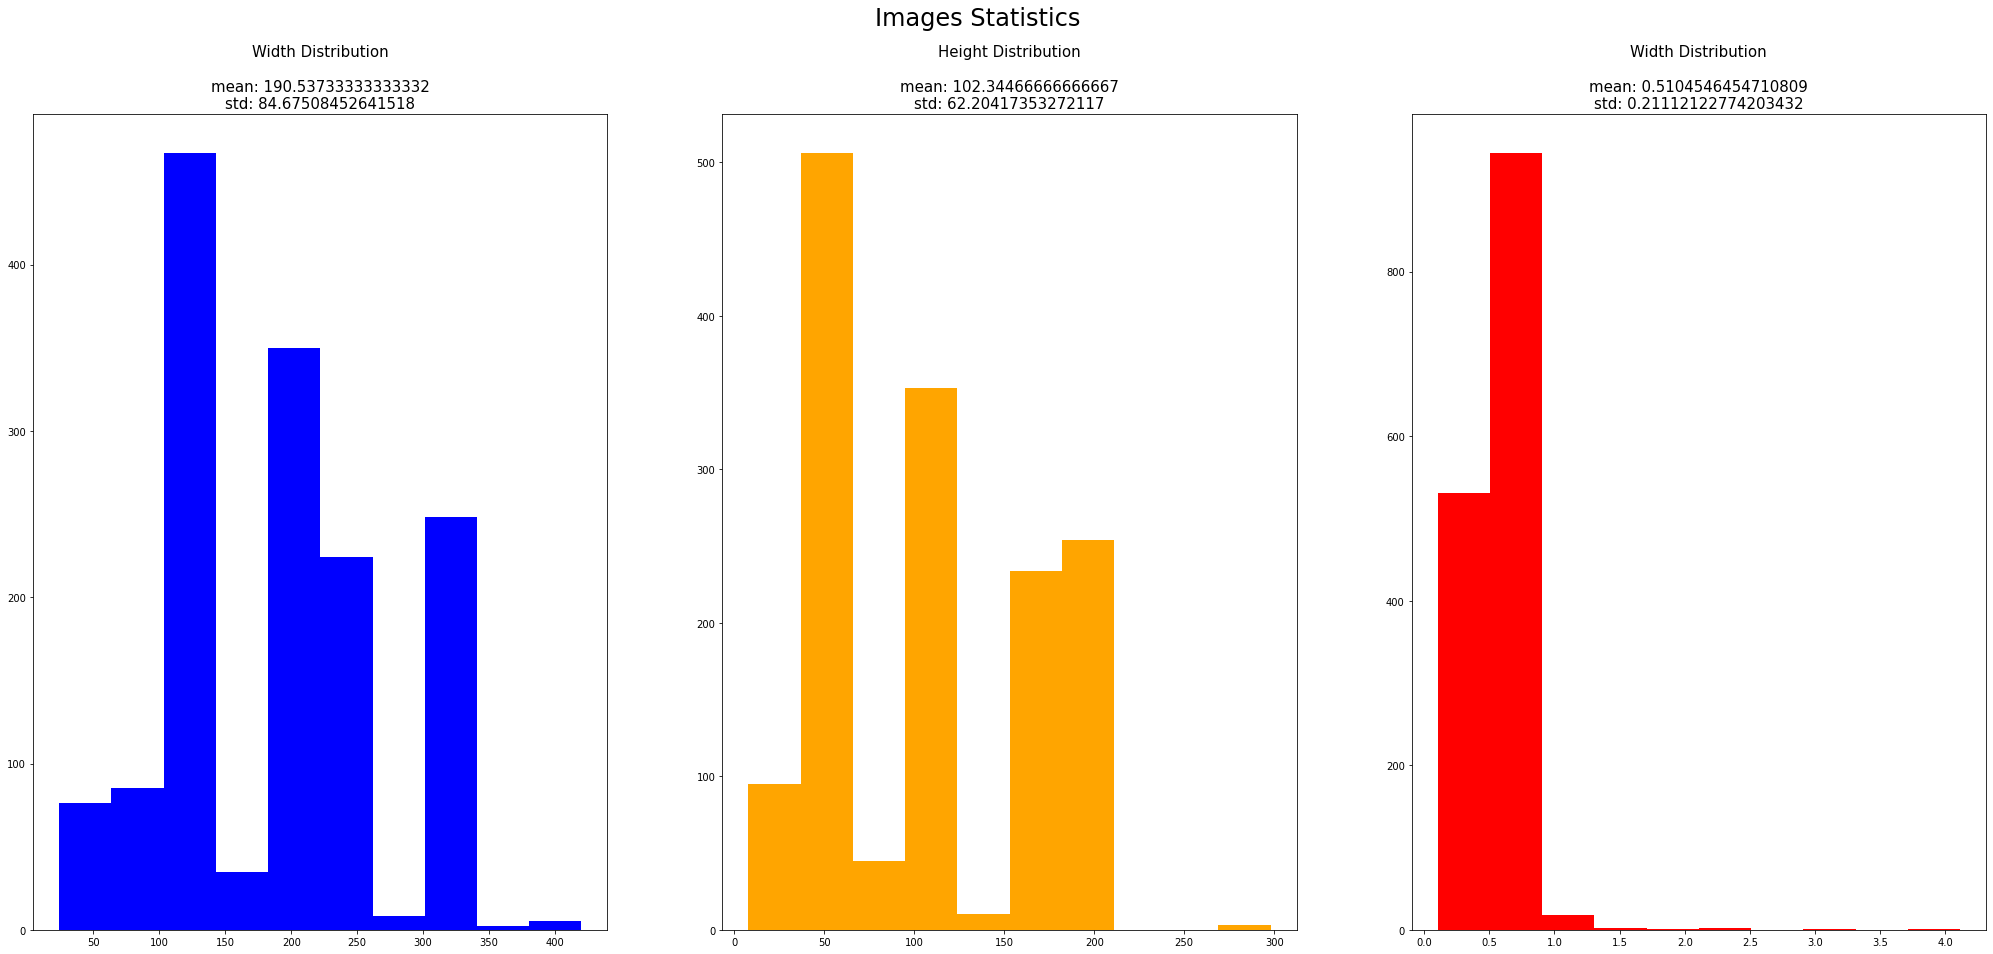

In [16]:
from scipy.stats import norm
# Dataset parameters
number_of_positive_samples_per_sequence = 100
number_of_negative_samples_per_sequence = 400
min_intersection_ratio = 0.8

# Build Dataset
imgs, labels = build_dataset_from_sequences(['0','1','2'],min_intersection_ratio=min_intersection_ratio, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence, visualize=False)

# Compute Image Statistics
statistics = dataset_statistics(imgs, labels, ['width','height','aspect_ratio','class_distribution'])

# Display Class Distribution
class_count = statistics['class_distribution']

plt.figure(figsize=(5,5))
plt.bar(['Non-Vehicles','Vehicles'],class_count, width=0.3)
plt.ylabel('Quantity')
plt.title("Class Distribution", fontsize='15')
plt.show()

# Display Stats Range Distribution
fig, axes = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(35)
fig.suptitle('Images Statistics', fontsize=24)

number_of_bins = 10
axes[0].hist(statistics['widths'], bins=number_of_bins, color='blue')
axes[0].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(statistics['widths']), std=np.std(statistics['widths'])), fontsize='15')

axes[1].hist(statistics['heights'], bins=number_of_bins, color='orange')
axes[1].set_title("Height Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(statistics['heights']), std=np.std(statistics['heights'])), fontsize='15')

axes[2].hist(statistics['aspect_ratios'], bins=number_of_bins, color='red')
axes[2].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(statistics['aspect_ratios']), std=np.std(statistics['aspect_ratios'])), fontsize='15')

plt.show()


##**Image Preprocessing**



*   Resize Images
*   Normalize Images
*   Extract HoG Features
*   Add Noise?






In [17]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
from random import shuffle
import time
from sklearn.preprocessing import StandardScaler
import cv2 as cv

def preprocess_images(imgs, orientations=9, resize_shape=(64,64), pixels_per_cell=(2,2), cells_per_block=(4,4), scaling=True, preprocessing_time=False, compute_spatial_features=False, spatial_bins=(8,8), visualize=False, grayscale=True):
  '''
  Preprocess an image.

  Params
  ------
  img: numpy array of shape (N, H,W,C)
  resize_shape: tuple - shape to which image are resized before hof computations
  scaling: boolean - indicates if feature vector must be scaled
  grayscale: boolean - indicate if image must be converted to grayscale
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation
  preprocessing_time: indicates if preprocessing time must be computed and returned

  Return
  ------
  return (features, (optional)hog_img, (optional)time) - HoG features extracted from the images,
  the HoG images, and the preprocessing times in ms
  '''
  N = len(imgs)
  H, W = resize_shape
  exec_times_ms = np.zeros(N)

  features = None

  if grayscale:
    multichannel = False
  else:
    C = 3
    multichannel = True

  if visualize:
    hog_imgs = None

  for i in range(N):
    start = time.time() # preprocessing start
    img = imgs[i]

    # 1. Convert to gray scale
    if grayscale:
      img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # 2. Resize
    img = resize(img,(H,W))

    # 4. Features Extraction

    # 4.1 HoG
    if visualize:
      hog_feature, hog_img = hog(img, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=multichannel, visualize=True)
    else:
      hog_feature = hog(img, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=multichannel, visualize=False)

    # 4.2 Spatial
    if compute_spatial_features:
      spatial_img = resize(img,spatial_bins)
      spatial_feature = spatial_img.flatten()
      feature = np.concatenate((hog_feature,spatial_feature), axis=-1)
    else:
      feature = hog_feature

    end = time.time() # preprocessing done

    # inti features array
    if features is None:
      features = np.zeros((N, len(feature)))
    features[i] = feature

    if visualize:
      if hog_imgs is None:
        hog_imgs = np.zeros((N,hog_img.shape[0],hog_img.shape[1]))
      hog_imgs[i] = hog_img

    exec_times_ms[i] = (end - start) * 1000 # in ms

  # 5. Scaling
  if scaling:
    # Scaler
    scaler = StandardScaler().fit(features)
    features = scaler.transform(features)

  # return package
  ret = list()
  ret.append(features)

  if preprocessing_time:
    ret.append(np.mean(exec_times_ms))

  if visualize:
    ret.append(hog_imgs)

  if len(ret) == 1:
    return ret[0]
  else:
    return tuple(ret)

###Display HoG Features 5 Vehicle and 5 Non-Vehicle


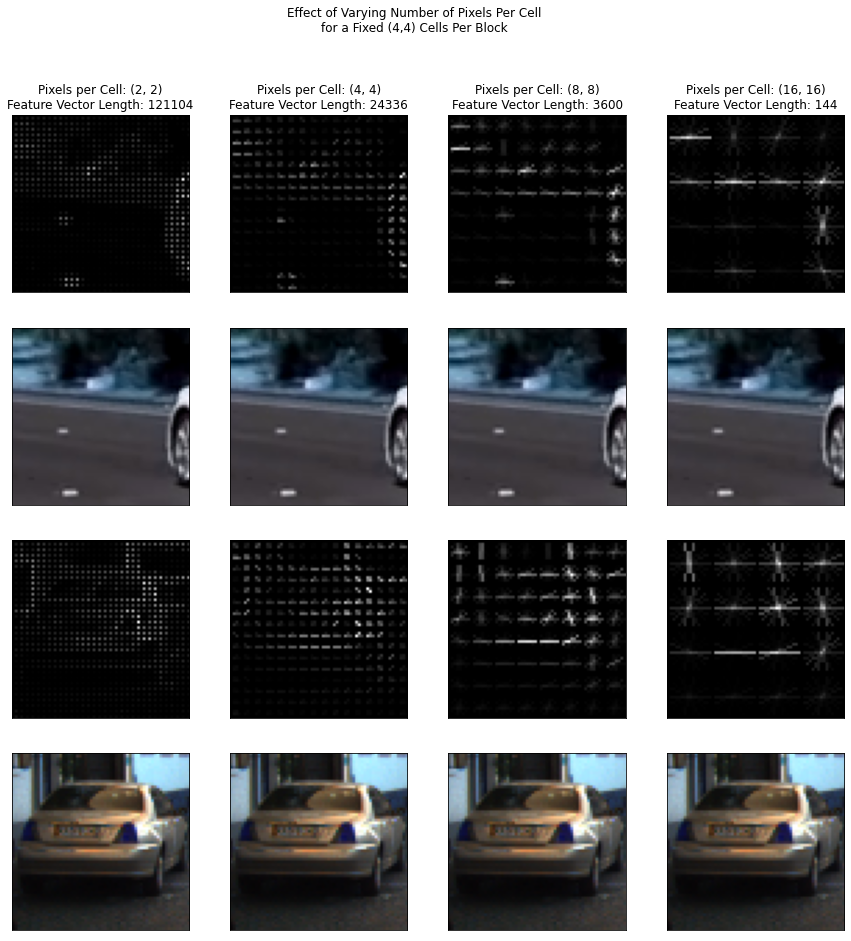

In [18]:
imgs, labels = build_dataset_from_udacity(number_of_positive_samples=1, number_of_negative_samples=1, visualize=False)

# Preprocessing params
orientations = 9
resize_shape = (64,64)
pixels_per_cell=(2,2)
cells_per_block = (4,4)

pixels_per_cell_range = [(2,2),(4,4),(8,8),(16,16)]

# Display Images along with predictions
fig, axes = plt.subplots(4,len(pixels_per_cell_range))
fig.suptitle("Effect of Varying Number of Pixels Per Cell\nfor a Fixed (4,4) Cells Per Block")
fig.set_figheight(15)
fig.set_figwidth(15)

number_of_samples = len(imgs)
while(True):
  vehicle_id = randint(0,number_of_samples-1)
  
  if labels[vehicle_id] == 1:
    break

while(True):
  non_vehicle_id = randint(0,number_of_samples-1)
  
  if labels[non_vehicle_id] == 0:
    break

for i, pixels_per_cell in enumerate(pixels_per_cell_range):
  features, hog_imgs = preprocess_images(imgs, orientations=orientations, resize_shape=resize_shape, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, scaling=True, preprocessing_time=False, compute_spatial_features=False, spatial_bins=(8,8), visualize=True, grayscale=True)
  number_of_samples = features.shape[0]
    
  axes[0][i].set_title("Pixels per Cell: {pix}\nFeature Vector Length: {f}".format(pix=str(pixels_per_cell),f=features.shape[1]))
  axes[0][i].set_xticks([]), axes[0][i].set_yticks([])
  axes[0][i].imshow(hog_imgs[non_vehicle_id],cmap='gray')

  axes[1][i].set_xticks([]), axes[1][i].set_yticks([])
  axes[1][i].imshow(imgs[non_vehicle_id],cmap='gray')
    
  
  axes[2][i].set_xticks([]), axes[2][i].set_yticks([])
  axes[2][i].imshow(hog_imgs[vehicle_id],cmap='gray')

  axes[3][i].set_xticks([]), axes[3][i].set_yticks([])
  axes[3][i].imshow(imgs[vehicle_id],cmap='gray')
    

plt.show()


###Effect of cells per block for fixed (2,2) number of pixels per cell


In [19]:
imgs, labels = build_dataset_from_udacity(number_of_positive_samples=1, number_of_negative_samples=1, visualize=False)

# Preprocessing params
orientations = 9
resize_shape = (64,64)
pixels_per_cell=(2,2)
cells_per_block = (4,4)

cells_per_block_range = [(2,2),(4,4),(8,8),(16,16)]


for i, cells_per_block in enumerate(cells_per_block_range):
  features, hog_imgs = preprocess_images(imgs, orientations=orientations, resize_shape=resize_shape, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, scaling=True, preprocessing_time=False, compute_spatial_features=False, spatial_bins=(8,8), visualize=True, grayscale=True)
  print("Cells Per Block: {c}, Feature Vector Length: {f}".format(c=str(cells_per_block),f=features.shape[1]))
    


Cells Per Block: (2, 2), Feature Vector Length: 34596
Cells Per Block: (4, 4), Feature Vector Length: 121104
Cells Per Block: (8, 8), Feature Vector Length: 360000
Cells Per Block: (16, 16), Feature Vector Length: 665856


###**3-Fold Cross-Validation**

For each validation, choose an image sequence to be the validation set

In [20]:
from random import shuffle
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np
import gc


# Performance Measures
def accuracy(tp, fp, tn, fn):
  return 100*(tp+tn)/(tp+fp+tn+fn)

def precision(tp, fp):
  return 100*tp/(tp+fp)

def recall(tp, fn):
  return 100*tp/(tp+fn)

"""
Perform 3-fold cross-validation for training SVM classifier for vehicle detection.

Params
------
fold_features: dicitonary of features used for K-fold cross-validation
fold_labels: dicitionary of labels used for K-fold cross-validation

other_features: additional features used for training
other_labels: additional labels used for training

I: number of iterations of cross-validation for each fold

classifier_type: possible values 'linear', 'rbf', 'rf'

C: regularization parameter for SVMs.

bagging: indicate if use bagging or not
n_estimators: # of estimator sin bagging

Return
------
Return accuracies, recalls, precisions and inference execution time for each fold.
"""
def cross_validation(fold_features, fold_labels, other_features=None, other_labels=None, I=1,classifier_type='linear', K=3, C=1000, bagging=False, n_estimators=10, n_estimators_random_forest = 500, criterion = 'entropy', max_depth = None, min_samples_split = 2):
  fold_ids = list(sequence_features.keys())

  # Performance measures
  tp, fp, tn, fn = np.zeros((I,K)), np.zeros((I,K)), np.zeros((I,K)), np.zeros((I,K))
  accuracies, recalls, precisions, inference_execution_times =  np.zeros((I,K)),  np.zeros((I,K)),  np.zeros((I,K)),  np.zeros((I,K))

  if other_features is not None:
    number_of_other_features = other_features.shape[0]
    other_inds = list(range(number_of_other_features))
    shuffle(other_inds)

  
  for i in range(I): # number of cross validations
    for k in range(K): # number of folds

      # val set
      x_val, y_val = fold_features[fold_ids[k]], sequence_labels[sequence_ids[k]]

      # train set
      x_train, y_train = None, None
      train_ids = list()
      if k == 0:
        train_ids += fold_ids[k+1:]
      elif k == K-1:
        train_ids += fold_ids[:k]
      else:
        train_ids += fold_ids[:k]
        train_ids += fold_ids[k+1:]

      for train_id in train_ids:
        if x_train is None:
          x_train, y_train = fold_features[train_id], fold_labels[train_id]
        else:
          x_train, y_train = np.concatenate((x_train, fold_features[train_id]),axis=0), np.concatenate((y_train, fold_labels[train_id]),axis=0)

      # Add other set
      if other_features is not None:
        x_train, y_train = np.concatenate((x_train, other_features),axis=0), np.concatenate((y_train, other_labels),axis=0)

      gc.collect()

      # LINEAR SVM
      if classifier_type == 'linear':
        # Bagging classifier
        if bagging:
          clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)
        # Binary Classifier
        else:
          clf = svm.SVC(gamma='scale', C=C)
      
      # RBF SVM
      elif classifier_type == 'rbf':
        # Bagging classifier
        if bagging:
          clf = BaggingClassifier(base_estimator=svm.LinearSVC(C=C), n_estimators=n_estimators, random_state=None)
        # Binary Classifier
        else:
          clf = svm.LinearSVC(C=C)

      # Random Forest
      elif classifier_type == 'rf':
        # Bagging classifier
        if bagging:
          clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion), n_estimators=n_estimators, random_state=None)
        # Random Forest Classifier
        else:
          clf = RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion)
           
      # Train
      clf.fit(x_train, y_train)

      # Predict
      start = time.time()
      y_pred = clf.predict(x_val)
      end = time.time()
      inference_execution_times[i,k] = (end-start)/x_val.shape[0]

      # Performance measurements
      tp[i,k] = np.sum(np.logical_and(y_pred == 1, y_val == 1))
      fp[i,k] = np.sum(np.logical_and(y_pred == 1, y_val == 0))
      tn[i,k] = np.sum(np.logical_and(y_pred == 0, y_val == 0))
      fn[i,k] = np.sum(np.logical_and(y_pred == 0, y_val == 1))

      accuracies[i,k] = accuracy(tp[i,k], fp[i,k], tn[i,k], fn[i,k])
      recalls[i,k] = recall(tp[i,k], fn[i,k])
      precisions[i,k] = precision(tp[i,k], fp[i,k])
  return (np.mean(accuracies,axis=0),np.std(accuracies,axis=0)), (np.mean(recalls,axis=0),np.std(recalls,axis=0)), (np.mean(precisions,axis=0),np.std(precisions,axis=0)), (np.mean(inference_execution_times,axis=0),np.std(inference_execution_times,axis=0))

###**Default Parameters**

####Parameters chosen from tuning reuslts

In [59]:
# Dataset parameters
min_intersection_ratio_default = 0.9
number_of_positive_samples_default = 1000
number_of_negative_samples_default = 1200
number_of_positive_samples_per_sequence_default = 500
number_of_negative_samples_per_sequence_default = 750

# Preprocessing parameters
resize_shape_default = (64,64)
orientations_default = 9 # number of orientation bins
pixels_per_cell_default = (8,8) # number of pixels per cell
cells_per_block_default = (2,2) # number of cells per block
compute_spatial_features_default=False
spatial_bins_default =(8,8)

#CV
K_default = 3
I_default = 3

classifier_type_default = 'linear'

# SVM parameters
C_default = 1000
bagging_default = False
n_estimators_default = 1

# Random Forest params
n_estimators_random_forest_default = 500
criterion_default = 'entropy'
max_depth_default = None
min_samples_split_default = 2

sequence_ids_default = ['0','1','2']
test_seq_id_default = '3'

###**Experiment 1**: Single Cross-Validation With Best Hyper-Parameters

In [60]:
import gc

sequence_features, sequence_labels = dict(), dict()
for seq_id in sequence_ids_default:
  seq_imgs, seq_labels = build_dataset_from_sequences(seq_id,min_intersection_ratio=min_intersection_ratio_default, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence_default, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence_default, visualize=False)
  seq_features = preprocess_images(seq_imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)
  sequence_features[seq_id], sequence_labels[seq_id] = seq_features, seq_labels

imgs, labels = build_dataset_from_udacity(number_of_positive_samples=number_of_positive_samples_default, number_of_negative_samples=number_of_negative_samples_default, visualize=False)
features = preprocess_images(imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)

# CV
accuracies, recalls, precisions, inference_exec_times = cross_validation(fold_features=sequence_features, fold_labels=sequence_labels, other_features=features, other_labels=labels, I=I_default,classifier_type=classifier_type_default, K=K_default, C=C_default, bagging=bagging_default, n_estimators=n_estimators_default, n_estimators_random_forest = n_estimators_random_forest_default, criterion = criterion_default, max_depth = max_depth_default, min_samples_split = min_samples_split_default)


# TODO: print results for each fold
for k in range(K):
  print("\nFold {k}".format(k=k+1))
  print("recall: {recall:.4f}%, std: {std:.4f}".format(recall=recalls[0][k], std=recalls[1][k]))
  print("accuracy: {acc:.4f}%, std: {std:.4f}".format(acc=accuracies[0][k],std=accuracies[1][k]))
  print("precision: {precision:.4f}%, {std:.4f}".format(precision=precisions[0][k], std=precisions[1][k]))
  print("Inference Execution Time: {t}ms, +/-{std:.4f}".format(t=1000*inference_exec_times[0][k], std=1000*inference_exec_times[1][k]))


# Overall Results
print("\nOverall Results")
print("recall: {recall:.4f}%, std: {std:.4f}".format(recall=np.mean(recalls[0]), std=np.mean(recalls[1])))
print("accuracy: {acc:.4f}%, std: {std:.4f}".format(acc=np.mean(accuracies[0]),std=np.mean(accuracies[1])))
print("precision: {precision:.4f}%, {std:.4f}".format(precision=np.mean(precisions[0]), std=np.mean(precisions[1])))
print("Inference Execution Time: {t}ms, +/-{std:.4f}".format(t=1000*np.mean(inference_exec_times[0]), std=1000*np.mean(inference_exec_times[1])))

del imgs
del features
for seq_id in sequence_ids_default:
  del sequence_features[seq_id]
  del sequence_labels[seq_id]
del labels
gc.collect()


Fold 0
recall: 87.4000%, std: 0.0000
accuracy: 89.0400%, std: 0.0000
precision: 85.5186%, 0.0000
Inference Execution Time: 5.112726593017578ms, +/-0.5584

Fold 1
recall: 84.8000%, std: 0.0000
accuracy: 86.3200%, std: 0.0000
precision: 81.6956%, 0.0000
Inference Execution Time: 4.739983177185059ms, +/-0.1920

Fold 2
recall: 80.4000%, std: 0.0000
accuracy: 88.8000%, std: 0.0000
precision: 90.5405%, 0.0000
Inference Execution Time: 5.039741452534994ms, +/-0.1762

Overall Results
recall: 84.2000%, std: 0.0000
accuracy: 88.0533%, std: 0.0000
precision: 85.9182%, 0.0000
Inference Execution Time: 4.96415040757921ms, +/-0.3089


0

###**Train & Save Model**

In [61]:
import pickle
import json
import yaml
import gc


def train_and_save_model(path, save_model=True, save_config=True, train_sequences=sequence_ids_default,classifier_type=classifier_type_default, number_of_positive_samples=number_of_positive_samples_default, number_of_negative_samples=number_of_negative_samples_default, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence_default, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence_default, min_intersection_ratio=min_intersection_ratio_default, resize_shape=resize_shape_default, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, orientations=orientations_default, pixels_per_cell=pixels_per_cell_default,cells_per_block=cells_per_block_default,C=C_default, bagging=bagging_default, n_estimators=n_estimators_default, n_estimators_random_forest=n_estimators_random_forest_default, criterion=criterion_default, max_depth=max_depth_default, min_samples_split=min_samples_split_default):
  '''
    Train a svm classifier with HoG features and save it.


    path: model path and name ex: classification/models/svm1

    Return the trained classifier.
  '''

  # Build Dataset
  imgs, labels = build_dataset_from_udacity(number_of_positive_samples=number_of_positive_samples, number_of_negative_samples=number_of_negative_samples, visualize=False)
  seq_imgs, seq_labels = build_dataset_from_sequences(sequence_ids,min_intersection_ratio=min_intersection_ratio, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence, visualize=False)
  imgs, labels = imgs + seq_imgs, np.concatenate((labels,seq_labels), axis=0)

  # Preprocess
  features = preprocess_images(imgs, orientations=orientations, resize_shape=resize_shape, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, scaling=True, preprocessing_time=False, compute_spatial_features=False, spatial_bins=spatial_bins, visualize=False, grayscale=True)

  # Shuffle
  number_of_samples = features.shape[0]
  inds = list(range(number_of_samples))
  shuffle(inds)

  x_train, y_train = features[inds], labels[inds]

  # LINEAR SVM
  if classifier_type == 'linear':
    # Bagging classifier
    if bagging:
      clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)
    # Binary Classifier
    else:
      clf = svm.SVC(gamma='scale', C=C)
  
  # RBF SVM
  elif classifier_type == 'rbf':
    # Bagging classifier
    if bagging:
      clf = BaggingClassifier(base_estimator=svm.LinearSVC(C=C), n_estimators=n_estimators, random_state=None)
    # Binary Classifier
    else:
      clf = svm.LinearSVC(C=C)

  # Random Forest
  elif classifier_type == 'rf':
    # Bagging classifier
    if bagging:
      clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion), n_estimators=n_estimators, random_state=None)
    # Random Forest Classifier
    else:
      clf = RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion)

  # Train
  clf.fit(x_train, y_train)

  # Save model
  if save_model:
    pickle.dump(clf,open(path+'.sav', 'wb'))

  # Save model hyperparameters
  if save_config:
    data = dict()
    data['dataset'] = dict()
    data['preprocessing'] = dict()
    data['clf'] = dict()

    data['dataset']['min_intersection_ratio'] = min_intersection_ratio
    data['dataset']['number_of_positive_samples'] = number_of_positive_samples
    data['dataset']['number_of_negative_samples'] = number_of_negative_samples
    data['dataset']['number_of_positive_samples_per_sequence'] = number_of_positive_samples_per_sequence
    data['dataset']['number_of_negative_samples_per_sequence'] = number_of_negative_samples_per_sequence
    
    data['preprocessing']['resize_shape'] = dict()
    data['preprocessing']['resize_shape']['y'], data['preprocessing']['resize_shape']['x'] = input_shape[0], input_shape[1]
    data['preprocessing']['orientations'] = orientations
    data['preprocessing']['compute_spatial_features'] = compute_spatial_features
    data['preprocessing']['spatial_bins'] = dict()
    data['preprocessing']['spatial_bins']['y'], data['preprocessing']['spatial_bins']['x'] = spatial_bins[0], spatial_bins[1]

    data['preprocessing']['pixels_per_cell'] = dict()
    data['preprocessing']['pixels_per_cell']['y'], data['preprocessing']['pixels_per_cell']['x'] = pixels_per_cell[0], pixels_per_cell[1]
    data['preprocessing']['cells_per_block'] = dict()
    data['preprocessing']['cells_per_block']['y'],data['preprocessing']['cells_per_block']['x'] = cells_per_block[0], cells_per_block[1]
    
    data['clf']['type'] = classifier_type
    data['clf']['C'] = C
    data['clf']['bagging'] = bagging
    data['clf']['n_estimators'] = n_estimators

    with open(path+'.yaml', "w") as outfile:
      yaml.dump(data, outfile)

    del imgs
    del features
    del seq_imgs
    del seq_labels
    del labels
    gc.collect()

  return clf

###Train a model

In [ ]:
path = "models/small"

# Dataset parameters
min_intersection_ratio = 0.7
number_of_positive_samples = 1000
number_of_negative_samples = 2000
number_of_positive_samples_per_sequence = 200
number_of_negative_samples_per_sequence = 400

# Preprocessing parameters
resize_shape = (64,64)
orientations = 9 # number of orientation bins
pixels_per_cell = (8,8) # number of pixels per cell
cells_per_block = (2,2) # number of cells per block
compute_spatial_features=False
spatial_bins =(8,8)

classifier_type = 'linear'

# SVM parameters
C = 1000
bagging = False
n_estimators = 1

# Random Forest params
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2


train_and_save_model(path, save_model=True, save_config=True, train_sequences=sequence_ids,classifier_type=classifier_type, number_of_positive_samples=number_of_positive_samples, number_of_negative_samples=number_of_negative_samples, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence, min_intersection_ratio=min_intersection_ratio, resize_shape=resize_shape, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)


SVC(C=1000)

###**Inference on Test Set**

In [51]:
import pickle
import gc
from random import shuffle

# TRAIN SET
# Build Dataset
train_imgs, train_labels = build_dataset_from_udacity(number_of_positive_samples=number_of_positive_samples_default, number_of_negative_samples=number_of_negative_samples_default, visualize=False)
seq_imgs, seq_labels = build_dataset_from_sequences(sequence_ids_default,min_intersection_ratio=min_intersection_ratio_default, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence_default, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence_default, visualize=False)
train_imgs, train_labels = train_imgs + seq_imgs, np.concatenate((train_labels,seq_labels), axis=0)

# Preprocess
train_features = preprocess_images(train_imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)

# Shuffle
number_of_samples = train_features.shape[0]
inds = list(range(number_of_samples))
shuffle(inds)

x_train, y_train = train_features[inds], train_labels[inds]


# TEST SET
# Build Dataset
test_imgs, test_labels = build_dataset_from_sequences(test_seq_id_default,min_intersection_ratio=min_intersection_ratio_default, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence_default, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence_default, visualize=False)

# Preprocess
test_features = preprocess_images(test_imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)

# Shuffle
number_of_test_samples = test_features.shape[0]
test_inds = list(range(number_of_test_samples))
# shuffle(test_inds)

x_test, y_test = test_features, test_labels

# LINEAR SVM
if classifier_type_default == 'linear':
  # Bagging classifier
  if bagging:
    clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C_default), n_estimators=n_estimators_default, random_state=None)
  # Binary Classifier
  else:
    clf = svm.SVC(gamma='scale', C=C_default)

# RBF SVM
elif classifier_type_default == 'rbf':
  # Bagging classifier
  if bagging:
    clf = BaggingClassifier(base_estimator=svm.LinearSVC(C=C_default), n_estimators=n_estimators_default, random_state=None)
  # Binary Classifier
  else:
    clf = svm.LinearSVC(C=C_default)

# Random Forest
elif classifier_type_default == 'rf':
  # Bagging classifier
  if bagging:
    clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n_estimators_random_forest_default, criterion=criterion_default), n_estimators=n_estimators_default, random_state=None)
  # Random Forest Classifier
  else:
    clf = RandomForestClassifier(n_estimators=n_estimators_random_forest_default, criterion=criterion_default)

# Train
clf.fit(x_train, y_train)

# clf = pickle.load(open("models/small.sav",'rb'))

y_pred = clf.predict(x_test)

tp = np.sum(np.logical_and(y_pred == 1, y_test == 1))
fp = np.sum(np.logical_and(y_pred == 1, y_test == 0))
tn = np.sum(np.logical_and(y_pred == 0, y_test == 0))
fn = np.sum(np.logical_and(y_pred == 0, y_test == 1))

print("recall: ",recall(tp,fn))
print("accuracy: ",accuracy(tp,fp, tn,fn))
print("precision: ",precision(tp,fp))

recall:  92.33333333333333
accuracy:  95.0
precision:  95.8477508650519


###Display 5 Vehicles and 5 Non-Vehicles Along with Predictions

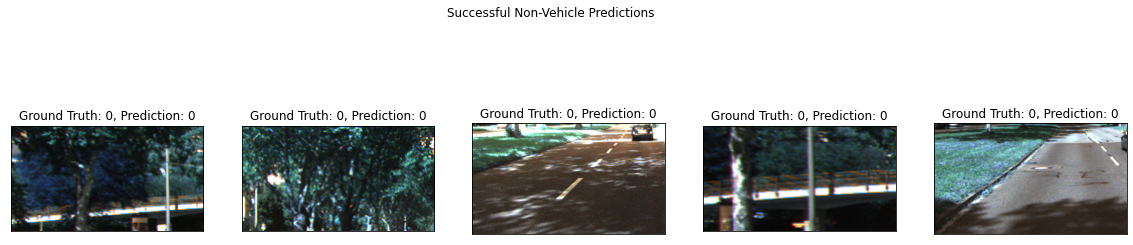

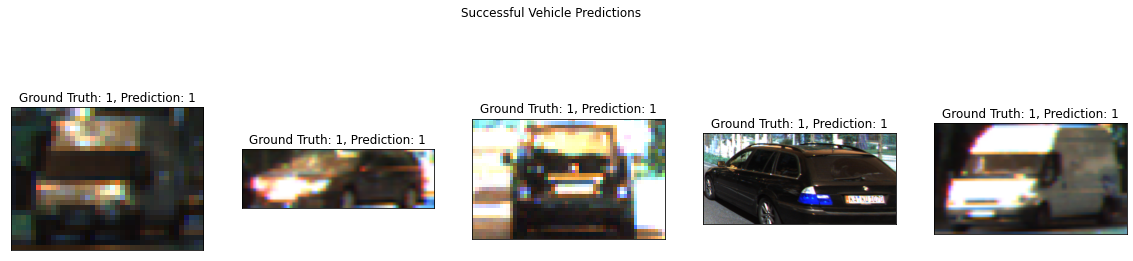

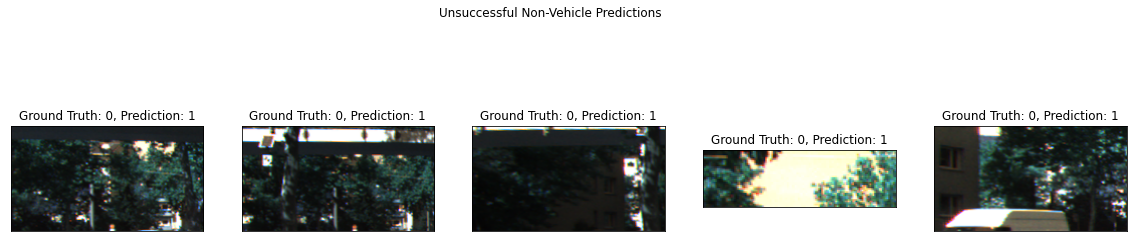

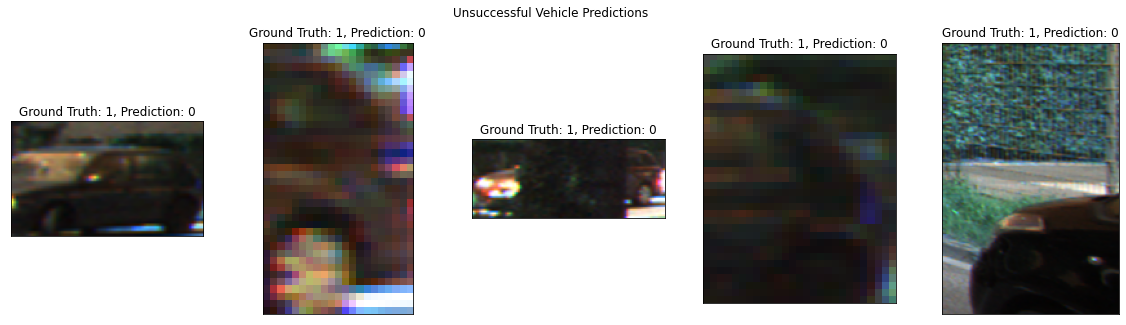

In [52]:

# Display Images along with predictions
fig, axes = plt.subplots(1,5)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle("Successful Non-Vehicle Predictions")

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_test_samples-1)
    
    if not (y_test[id] == 0 and y_pred[id] == 0):
      continue

    if id in visited:
      continue

    pred = y_pred[id]
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=y_test[id], pred=y_pred[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(test_imgs[id])
    visited.append(id)
    break

plt.show()

fig, axes = plt.subplots(1,5)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle("Successful Vehicle Predictions")

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_test_samples-1)
    
    if not (y_test[id] == 1 and y_pred[id] == 1):
      continue

    if id in visited:
      continue

    pred = y_pred[id]
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=y_test[id], pred=y_pred[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(test_imgs[id])
    visited.append(id)
    break

plt.show()


fig, axes = plt.subplots(1,5)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle("Unsuccessful Non-Vehicle Predictions")


visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_test_samples-1)
    
    if not (y_test[id] == 0 and y_pred[id] == 1):
      continue

    if id in visited:
      continue

    pred = y_pred[id]
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=y_test[id], pred=y_pred[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(test_imgs[id])
    visited.append(id)
    break

plt.show()

fig, axes = plt.subplots(1,5)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle("Unsuccessful Vehicle Predictions")

visited = list()
for i in range(5):
  while(True):
    id = randint(0,number_of_test_samples-1)
    
    if not (y_test[id] == 1 and y_pred[id] == 0):
      continue

    if id in visited:
      continue

    pred = y_pred[id]
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=y_test[id], pred=y_pred[id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(test_imgs[id])
    visited.append(id)
    break

plt.show()

### **Hyper-Parameter Tuning**

#### Param 1: Number of Positive Samples

In [ ]:
import gc

param_range = [100, 500, 1000, 2500, 5000, 7500, 10000]

recalls, recalls_std = np.zeros(len(param_range)), np.zeros(len(param_range))
accuracies, accuracies_std = np.zeros(len(param_range)), np.zeros(len(param_range))
precisions, precisions_std = np.zeros(len(param_range)), np.zeros(len(param_range))
inference_exec_times, inference_exec_times_std = np.zeros(len(param_range)), np.zeros(len(param_range))
for i, total_number_of_samples in enumerate(param_range):

  number_of_samples_per_sequence = int(total_number_of_samples/2)
  number_of_positive_samples_per_sequence = int(0.4*number_of_samples_per_sequence)
  number_of_negative_samples_per_sequence = number_of_samples_per_sequence - number_of_positive_samples_per_sequence

  number_of_samples_from_db = total_number_of_samples - number_of_samples_per_sequence
  number_of_positive_samples = int(0.4*number_of_samples_from_db)
  number_of_negative_samples = number_of_samples_from_db - number_of_positive_samples

  sequence_features, sequence_labels = dict(), dict()
  for seq_id in sequence_ids_default:
    seq_imgs, seq_labels = build_dataset_from_sequences(seq_id,min_intersection_ratio=min_intersection_ratio_default, number_of_positive_samples_per_sequence=number_of_positive_samples_per_sequence, number_of_negative_samples_per_sequence=number_of_negative_samples_per_sequence, visualize=False)
    seq_features = preprocess_images(seq_imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)
    sequence_features[seq_id], sequence_labels[seq_id] = seq_features, seq_labels

  imgs, labels = build_dataset_from_udacity(number_of_positive_samples=number_of_positive_samples, number_of_negative_samples=number_of_negative_samples, visualize=False)
  features = preprocess_images(imgs, orientations=orientations_default, resize_shape=resize_shape_default, pixels_per_cell=pixels_per_cell_default, cells_per_block=cells_per_block_default, scaling=True, preprocessing_time=False, compute_spatial_features=compute_spatial_features_default, spatial_bins=spatial_bins_default, visualize=False, grayscale=True)

  # CV
  acc, rec, prec, inf = cross_validation(fold_features=sequence_features, fold_labels=sequence_labels, other_features=features, other_labels=labels, I=I_default,classifier_type=classifier_type_default, K=K_default, C=C_default, bagging=bagging_default, n_estimators=n_estimators_default, n_estimators_random_forest = n_estimators_random_forest_default, criterion = criterion_default, max_depth = max_depth_default, min_samples_split = min_samples_split_default)

  recalls[i], recalls_std[i] = np.mean(acc[0]), np.mean(acc[1])
  accuracies[i], accuracies_std[i] = np.mean(rec[0]), np.mean(rec[1])
  precisions[i], precisions_std[i] = np.mean(prec[0]), np.mean(prec[1])
  inference_exec_times[i], inference_exec_times_std[i] = 1000*np.mean(inf[0]), 1000*np.mean(inf[1])

  # del sequences
  del imgs
  for seq_id in sequence_ids_default:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  del features
  del labels
  gc.collect()


# Display
param_name = "Total Number of Samples"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].errorbar(param_range,accuracies, yerr=accuracies_std)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].errorbar(param_range,recalls, yerr=recalls_std)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].errorbar(param_range,precisions, yerr=precisions_std)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].errorbar(param_range,inference_exec_times, yerr=inference_exec_times_std)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 3: Parameter C

In [ ]:
import gc

param_range = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build and Preprocess
sequence_features, sequence_labels = dict(), dict()
for seq_id in sequence_ids:
  seq_imgs, seq_labels = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
  seq_features = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)
  sequence_features[seq_id], sequence_labels[seq_id] = seq_features, seq_labels

imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)
features = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,  compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

# CV
for i, C in enumerate(param_range):
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
for seq_id in sequence_ids:
  del sequence_features[seq_id]
  del sequence_labels[seq_id]
del features
del labels
gc.collect()

# Display
param_name = "C"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_xscale('log')
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
axes[1].set_xscale('log')
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
axes[2].set_xscale('log')
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
axes[3].set_xscale('log')
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

KeyboardInterrupt: ignored

#### Param 4: Number of Estimators in Bagging

In [ ]:
import gc

param_range = [1,10, 20, 30, 40, 50]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_features, sequence_labels = dict(), dict()
for seq_id in sequence_ids:
  seq_imgs, seq_labels = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
  seq_features = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)
  sequence_features[seq_id], sequence_labels[seq_id] = seq_features, seq_labels

imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)
features = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,  compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

# CV
for i, n_estimators in enumerate(param_range):
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
for seq_id in sequence_ids:
  del sequence_features[seq_id]
  del sequence_labels[seq_id]
del labels
gc.collect()

# Display
param_name = "Number of Estimators"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 5: HoG Block Shape

In [ ]:
import gc

param_range = [(2,2),(3,3),(4,4), (8,8),(16,16)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_imgs, sequence_features, sequence_labels  = dict(), dict(), dict()
for seq_id in sequence_ids:
  sequence_imgs[seq_id], sequence_labels[seq_id] = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, cells_per_block in enumerate(param_range):
  # Preprocess Dataset
  for seq_id in sequence_ids:
    sequence_features[seq_id] = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

  # Preprocess
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  for seq_id in sequence_ids:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Cells Per Block"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

KeyError: ignored

###Param 6: HoG Cell Shape

In [ ]:
import gc

param_range = [(2,2),(4,4),(8,8), (16,16)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_imgs, sequence_features, sequence_labels  = dict(), dict(), dict()
for seq_id in sequence_ids:
  sequence_imgs[seq_id], sequence_labels[seq_id] = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, pixels_per_cell in enumerate(param_range):
  # Preprocess Dataset
  for seq_id in sequence_ids:
    sequence_features[seq_id] = preprocess_images_v2(sequence_imgs[seq_id], orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

  # Preprocess
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time
  
  del features
  for seq_id in sequence_ids:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Pixels Per Cell"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

###Param 7: Input Shape

In [ ]:
import gc

param_range = [(64,64), (80,80), (128,128), (256,256)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_imgs, sequence_features, sequence_labels  = dict(), dict(), dict()
for seq_id in sequence_ids:
  sequence_imgs[seq_id], sequence_labels[seq_id] = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, input_shape in enumerate(param_range):
  # Preprocess Dataset
  for seq_id in sequence_ids:
    sequence_features[seq_id] = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

  # Preprocess
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  for seq_id in sequence_ids:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Input Shape"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(35)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

###Param 8: Number of orientation bins

In [ ]:
import gc

param_range = [4,9,12,16]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_imgs, sequence_features, sequence_labels  = dict(), dict(), dict()
for seq_id in sequence_ids:
  sequence_imgs[seq_id], sequence_labels[seq_id] = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, orientations in enumerate(param_range):
  # Preprocess Dataset
  for seq_id in sequence_ids:
    sequence_features[seq_id] = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

  # Preprocess
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  for seq_id in sequence_ids:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Number of Orientations Bins"

fig, axes = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(35)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

###Param 9: Spatial Bins Size

In [ ]:
import gc

param_range = [(4,4), (8,8), (16,16)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequence_imgs, sequence_features, sequence_labels  = dict(), dict(), dict()
for seq_id in sequence_ids:
  sequence_imgs[seq_id], sequence_labels[seq_id] = build_dataset_from_sequences([seq_id],min_intersection_ratio=min_intersection_ratio, positive_negative_ratio=sequences_positive_negative_ratio, number_of_positive_samples=number_of_positive_samples_per_sequence, resize_shape=input_shape, visualize=False)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, spatial_bins in enumerate(param_range):
  # Preprocess Dataset
  for seq_id in sequence_ids:
    sequence_features[seq_id] = preprocess_images_v2(seq_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, spatial_bins=spatial_bins)

  # Preprocess
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, sequence_features, sequence_labels, classifier_type=classifier_type, I=I, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest = n_estimators_random_forest, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  for seq_id in sequence_ids:
    del sequence_features[seq_id]
    del sequence_labels[seq_id]
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Spatial Bins Shape"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(35)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()